## Importing Libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from tqdm import tqdm
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define some sample tags for the dataset
tags = [
    "symptoms",
    "treatment",
    "prevention",
    "diagnosis",
    "risk_factors",
    "medications"
]

# Define sample question-answer pairs for each tag
data = {
    "symptoms": [
        ("What are the common symptoms of heart disease?", "Common symptoms include chest pain, shortness of breath, and fatigue."),
        ("Can heart disease cause arm pain?", "Yes, heart disease can cause pain that radiates to the arm."),
        ("What are the early signs of heart disease?", "Early signs include fatigue, shortness of breath, and chest discomfort."),
        ("Can heart disease cause leg pain?", "Yes, heart disease can cause pain in the legs, especially if there is poor circulation."),
        ("Are there any silent symptoms of heart disease?", "Yes, some people may experience heart disease with no noticeable symptoms."),
        ("What are the symptoms of a heart attack?", "Symptoms include chest pain, shortness of breath, nausea, and lightheadedness."),
        ("Can heart disease cause back pain?", "Yes, back pain can be a symptom, especially in women."),
        ("What are the symptoms of heart failure?", "Symptoms include shortness of breath, swelling in legs, and fatigue."),
        ("Can heart disease cause jaw pain?", "Yes, jaw pain can be a symptom of heart disease, particularly in women."),
        ("What are the symptoms of coronary artery disease?", "Symptoms include chest pain, shortness of breath, and heart palpitations."),
    ],
    "treatment": [
        ("What treatments are available for heart disease?", "Treatments include lifestyle changes, medications, and surgery."),
        ("Can heart disease be treated with medication?", "Yes, there are several medications available to treat heart disease."),
        ("Is surgery necessary for heart disease?", "In some cases, surgery may be required to treat heart disease."),
        ("What lifestyle changes can help treat heart disease?", "Lifestyle changes include a healthy diet, regular exercise, and quitting smoking."),
        ("What are the different types of heart surgeries?", "Common types include coronary artery bypass grafting (CABG) and angioplasty."),
        ("Can heart disease be reversed?", "Some forms of heart disease can be managed and improved with treatment, but not completely reversed."),
        ("What role does diet play in treating heart disease?", "A heart-healthy diet can significantly improve heart disease outcomes."),
        ("How does exercise help in treating heart disease?", "Regular exercise helps improve heart function and overall cardiovascular health."),
        ("Are there any alternative treatments for heart disease?", "Some alternative treatments include acupuncture, yoga, and herbal supplements."),
        ("How important is medication adherence in treating heart disease?", "Adherence to medication is crucial to effectively manage and treat heart disease."),
    ],
    "prevention": [
        ("How can I prevent heart disease?", "Prevention methods include a healthy diet, regular exercise, and avoiding smoking."),
        ("Can heart disease be prevented with lifestyle changes?", "Yes, lifestyle changes can significantly reduce the risk of heart disease."),
        ("What dietary changes can help prevent heart disease?", "Eating a diet rich in fruits, vegetables, and whole grains can help prevent heart disease."),
        ("How does exercise prevent heart disease?", "Regular exercise strengthens the heart and improves circulation."),
        ("Can quitting smoking prevent heart disease?", "Yes, quitting smoking is one of the most effective ways to reduce the risk of heart disease."),
        ("What role does stress management play in heart disease prevention?", "Managing stress through techniques like meditation and yoga can help prevent heart disease."),
        ("Can alcohol consumption affect heart disease risk?", "Excessive alcohol consumption can increase the risk of heart disease."),
        ("How does maintaining a healthy weight prevent heart disease?", "A healthy weight reduces the strain on the heart and lowers risk factors."),
        ("What is the impact of high blood pressure on heart disease?", "High blood pressure is a major risk factor for heart disease."),
        ("Can regular medical check-ups help in preventing heart disease?", "Yes, regular check-ups can help detect and manage risk factors early."),
    ],
    "diagnosis": [
        ("How is heart disease diagnosed?", "Heart disease is diagnosed using tests such as ECG, echocardiogram, and stress tests."),
        ("What tests are used to diagnose heart disease?", "Common tests include ECG, echocardiogram, and blood tests."),
        ("Can heart disease be detected early?", "Yes, early detection is possible through regular check-ups and screening tests."),
        ("What is an ECG?", "An ECG is an electrocardiogram, a test that measures the electrical activity of the heart."),
        ("How does an echocardiogram help diagnose heart disease?", "An echocardiogram uses ultrasound to create images of the heart, helping diagnose various heart conditions."),
        ("What is a stress test?", "A stress test evaluates how the heart works during physical activity."),
        ("Can blood tests detect heart disease?", "Yes, certain blood tests can detect markers that indicate heart disease."),
        ("What is a coronary angiography?", "A coronary angiography is a procedure that uses contrast dye and X-rays to see how blood flows through the heart's arteries."),
        ("How is heart disease diagnosed in women?", "Women may have different symptoms, and tests like ECG, echocardiogram, and stress tests are used."),
        ("What is the role of a cardiologist in diagnosing heart disease?", "A cardiologist is a heart specialist who diagnoses and treats heart disease."),
    ],
    "risk_factors": [
        ("What are the risk factors for heart disease?", "Risk factors include high blood pressure, high cholesterol, and smoking."),
        ("Can genetics increase the risk of heart disease?", "Yes, a family history of heart disease can increase the risk."),
        ("How does smoking affect the risk of heart disease?", "Smoking significantly increases the risk of developing heart disease."),
        ("What is the impact of high cholesterol on heart disease?", "High cholesterol can lead to plaque buildup in the arteries, increasing the risk of heart disease."),
        ("How does obesity contribute to heart disease?", "Obesity increases the risk of heart disease by causing high blood pressure, high cholesterol, and diabetes."),
        ("Can diabetes increase the risk of heart disease?", "Yes, people with diabetes are at a higher risk for heart disease."),
        ("What role does high blood pressure play in heart disease?", "High blood pressure can damage the arteries, making them more susceptible to heart disease."),
        ("How does age affect the risk of heart disease?", "The risk of heart disease increases with age."),
        ("Can stress increase the risk of heart disease?", "Chronic stress can contribute to heart disease by increasing blood pressure and other risk factors."),
        ("What is the role of physical inactivity in heart disease risk?", "Lack of physical activity can lead to weight gain, high blood pressure, and other risk factors for heart disease."),
    ],
    "medications": [
        ("What medications are used to treat heart disease?", "Common medications include statins, beta-blockers, and ACE inhibitors."),
        ("Can medication alone manage heart disease?", "In some cases, medication alone can manage heart disease, but lifestyle changes are also important."),
        ("What are the side effects of heart disease medications?", "Side effects vary by medication but can include dizziness, fatigue, and nausea."),
        ("How do statins help in heart disease?", "Statins help lower cholesterol levels, reducing the risk of heart disease."),
        ("What are beta-blockers?", "Beta-blockers are medications that reduce blood pressure and heart rate."),
        ("How do ACE inhibitors work?", "ACE inhibitors help relax blood vessels and reduce blood pressure."),
        ("Can aspirin help prevent heart disease?", "Aspirin can help prevent blood clots, which can reduce the risk of heart attacks."),
        ("What is the role of anticoagulants in heart disease?", "Anticoagulants help prevent blood clots, reducing the risk of stroke and heart attack."),
        ("Are there any natural supplements for heart disease?", "Some supplements like omega-3 fatty acids may help, but they should be used under medical supervision."),
        ("How important is medication adherence in treating heart disease?", "Adherence to medication is crucial to effectively manage and treat heart disease."),
    ]
}

df = pd.DataFrame(data)
df.to_csv("heart_disease_qa_data.csv", index=False)
print("CSV file 'heart_disease_qa_data.csv' has been created.")


CSV file 'heart_disease_qa_data.csv' has been created.


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Data Columns

In [22]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/CardioGuardian_Chatbot/heart_disease_qa_data.csv')

print(df.columns)


Index(['symptoms', 'treatment', 'prevention', 'diagnosis', 'risk_factors',
       'medications'],
      dtype='object')


## Data Preprocessing

In [23]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/CardioGuardian_Chatbot/heart_disease_qa_data.csv')

# Function to safely evaluate the string representations
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

#### Creating DataFrame

In [24]:
# Initialize an empty list to store the extracted data
data = []

# Iterate over each column (tag) in the dataframe
for tag in df.columns:
    # Iterate over each row in the column
    for row in df[tag]:
        # Convert the string representation to a tuple
        pair = safe_literal_eval(row)
        # Check if the converted value is a tuple and has exactly 2 elements
        if isinstance(pair, tuple) and len(pair) == 2:
            question, answer = pair
            data.append((question, answer, tag))

# Convert the data into a DataFrame
flat_df = pd.DataFrame(data, columns=['questions', 'answers', 'tags'])

# Print the flattened DataFrame to check its contents
print("Flattened DataFrame:")
print(flat_df.head())

Flattened DataFrame:
                                         questions  \
0   What are the common symptoms of heart disease?   
1                Can heart disease cause arm pain?   
2       What are the early signs of heart disease?   
3                Can heart disease cause leg pain?   
4  Are there any silent symptoms of heart disease?   

                                             answers      tags  
0  Common symptoms include chest pain, shortness ...  symptoms  
1  Yes, heart disease can cause pain that radiate...  symptoms  
2  Early signs include fatigue, shortness of brea...  symptoms  
3  Yes, heart disease can cause pain in the legs,...  symptoms  
4  Yes, some people may experience heart disease ...  symptoms  


#### Data Cleaning

In [25]:
# Function for text cleaning
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    return text.strip()

# Apply the text cleaning function to the questions and answers
flat_df['questions'] = flat_df['questions'].apply(clean_text)
flat_df['answers'] = flat_df['answers'].apply(clean_text)

#### Tokenization

In [26]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the questions and answers
def tokenize_data(questions, answers, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []

    for question, answer in zip(questions, answers):
        encoded_data = tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Tokenize questions and answers
input_ids, attention_masks = tokenize_data(flat_df['questions'], flat_df['answers'], tokenizer)

# Check the shapes
print(f'Input IDs shape: {input_ids.shape}')
print(f'Attention Masks shape: {attention_masks.shape}')

# Convert tags to numerical labels
tags = flat_df['tags'].unique().tolist()
tag_to_id = {tag: idx for idx, tag in enumerate(tags)}
labels = flat_df['tags'].apply(lambda x: tag_to_id[x])

# Convert labels to tensor
labels = torch.tensor(labels.values)

# Split the data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.1, random_state=42)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input IDs shape: torch.Size([60, 128])
Attention Masks shape: torch.Size([60, 128])


#### Creating DataLoader

In [27]:
# Create DataLoader
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

print("DataLoader created successfully.")

DataLoader created successfully.


### Fine-tuning the BERT Model

In [28]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Load pre-trained BERT model for sequence classification with dropout
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(tags))
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)  # Reduced learning rate slightly
total_steps = len(train_dataloader) * 5  # Increased epochs to 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop with gradient accumulation and early stopping
epochs = 5
accumulation_steps = 4  # Gradient accumulation to simulate larger batch size
patience = 2  # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        batch_input_ids, batch_attention_masks, batch_labels = tuple(t.to(device) for t in batch)

        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss / accumulation_steps  # Normalize loss to account for gradient accumulation
        total_loss += loss.item()

        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    total_eval_loss = 0

    for batch in tqdm(val_dataloader, desc="Validation"):
        batch_input_ids, batch_attention_masks, batch_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f"Average validation loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))


Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Training: 100%|██████████| 4/4 [01:12<00:00, 18.24s/it]


Average training loss: 0.4750


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Average validation loss: 1.6551
Epoch 2/5


Training: 100%|██████████| 4/4 [01:18<00:00, 19.63s/it]


Average training loss: 0.4647


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


Average validation loss: 1.6674
Epoch 3/5


Training: 100%|██████████| 4/4 [01:13<00:00, 18.26s/it]


Average training loss: 0.4371


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Average validation loss: 1.6566
Early stopping triggered.


<All keys matched successfully>

### Evaluating the Model

In [34]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Evaluate the model on the validation set
for batch in tqdm(val_dataloader, desc="Evaluating"):
    batch_input_ids, batch_attention_masks, batch_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).flatten()

    true_labels.extend(batch_labels.cpu().numpy())
    predictions.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Ensure all tags are considered in the classification report
unique_labels = np.unique(true_labels)
report = classification_report(true_labels, predictions, labels=unique_labels, target_names=[tags[i] for i in unique_labels])

# Print the classification report
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", report)


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
               precision    recall  f1-score   support

    symptoms       0.00      0.00      0.00       2.0
   treatment       0.00      0.00      0.00       1.0
   diagnosis       0.00      0.00      0.00       1.0
risk_factors       0.00      0.00      0.00       1.0
 medications       0.00      0.00      0.00       1.0

    accuracy                           0.00       6.0
   macro avg       0.00      0.00      0.00       6.0
weighted avg       0.00      0.00      0.00       6.0



## Perfomance Metrics

In [31]:
# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Ensure all tags are considered in the classification report
unique_labels = np.unique(true_labels)
report = classification_report(true_labels, predictions, labels=unique_labels, target_names=[tags[i] for i in unique_labels])

# Print the classification report
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", report)

Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
               precision    recall  f1-score   support

    symptoms       0.00      0.00      0.00       2.0
   treatment       0.00      0.00      0.00       1.0
   diagnosis       0.00      0.00      0.00       1.0
risk_factors       0.00      0.00      0.00       1.0
 medications       0.00      0.00      0.00       1.0

    accuracy                           0.00       6.0
   macro avg       0.00      0.00      0.00       6.0
weighted avg       0.00      0.00      0.00       6.0



#### Confusion Matrix

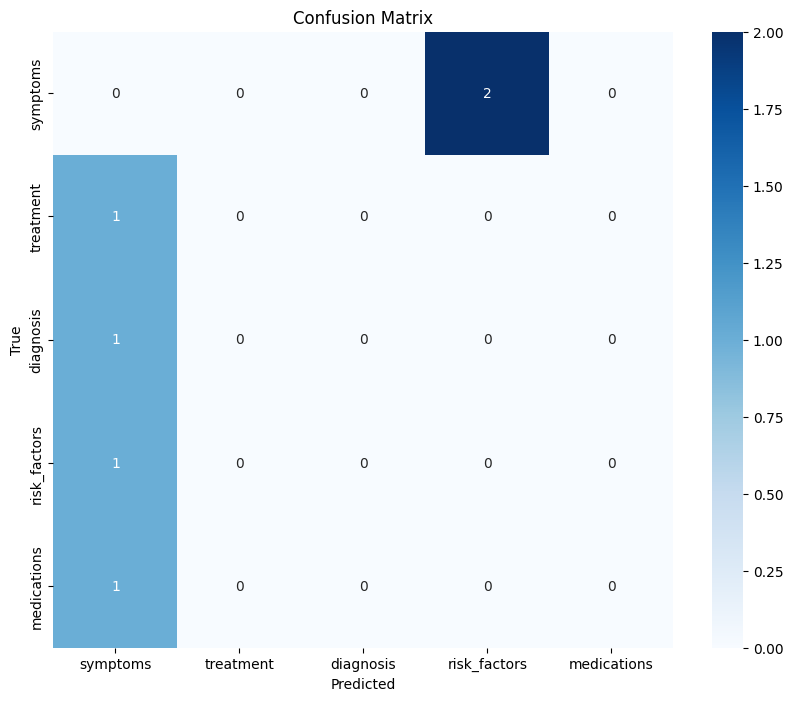

In [32]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[tags[i] for i in unique_labels], yticklabels=[tags[i] for i in unique_labels])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Error Analysis

In [33]:
# Error Analysis
errors = []
for i, (true_label, prediction) in enumerate(zip(true_labels, predictions)):
    if true_label != prediction:
        errors.append((flat_df.iloc[i]['questions'], flat_df.iloc[i]['answers'], tags[true_label], tags[prediction]))

# Print some examples of errors
print("\nSome Error Analysis Examples:\n")
for error in errors[:10]:  # Print the first 10 errors
    print(f"Question: {error[0]}")
    print(f"Answer: {error[1]}")
    print(f"True Tag: {error[2]}")
    print(f"Predicted Tag: {error[3]}")
    print("\n")


Some Error Analysis Examples:

Question: What are the common symptoms of heart disease?
Answer: Common symptoms include chest pain, shortness of breath, and fatigue.
True Tag: symptoms
Predicted Tag: risk_factors


Question: Can heart disease cause arm pain?
Answer: Yes, heart disease can cause pain that radiates to the arm.
True Tag: symptoms
Predicted Tag: risk_factors


Question: What are the early signs of heart disease?
Answer: Early signs include fatigue, shortness of breath, and chest discomfort.
True Tag: diagnosis
Predicted Tag: symptoms


Question: Can heart disease cause leg pain?
Answer: Yes, heart disease can cause pain in the legs, especially if there is poor circulation.
True Tag: risk_factors
Predicted Tag: symptoms


Question: Are there any silent symptoms of heart disease?
Answer: Yes, some people may experience heart disease with no noticeable symptoms.
True Tag: treatment
Predicted Tag: symptoms


Question: What are the symptoms of a heart attack?
Answer: Symptoms 